# BoW Model

In this notebook, I will use count vector related measures (e.g. TF-IDF) to classify the sentiment.  

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import pickle

from timeit import default_timer as timer
from custom_functions import clean_up, evaluating, scoring, get_pred

In [2]:
X_train = pd.read_pickle('PKL/X_train_fin.pkl')
X_val = pd.read_pickle('PKL/X_val_fin.pkl')
y_train = pd.read_csv('DATA/y_train.csv', index_col=0)
y_val = pd.read_csv('DATA/y_val.csv', index_col=0)

In [3]:
y_train = y_train['sentiment']
y_val = y_val['sentiment']

## Evaluation Metrics
It is a multi-class classification problem with class imbalance. Since the goal of the project is to build a model that accurately classifies positive, negative or neutral sentiment than detecting any specific class, while significant class imbalance exists, I'll use macro f1 score as evaluation metric. I'll also look at cohen's kappa score for overall model quality.

## Count Vectors
I'll start with simple count vectors.

In [4]:
from sklearn.feature_extraction.text import CountVectorizer

countvec = CountVectorizer(ngram_range = (1, 2))
X_train_count = countvec.fit_transform(X_train.tweet)

### Class Imbalance
Currently our dataset has a class imbalance issue. I'll first try to resolve this by oversampling using SMOTE.

In [5]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(n_jobs = 3, random_state=22)
X_train_count, y_train_count = smote.fit_resample(X_train_count, y_train)

### Naive-Bayes Model

In [6]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, auc, roc_curve, precision_recall_curve

mn_nb = MultinomialNB()
model = Pipeline([('vectorize', countvec), ('classify', mn_nb)])
model['classify'].fit(X_train_count, y_train_count)

MultinomialNB()

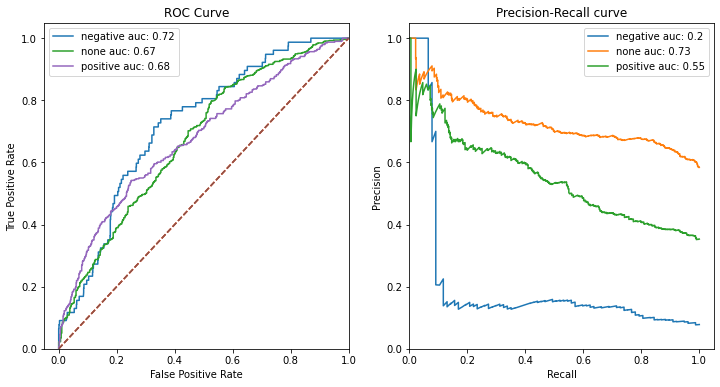

accuracy score:  0.615 cohens kappa:  0.2478
                                    precision    recall  f1-score   support

                  Negative emotion       0.24      0.10      0.14        77
No emotion toward brand or product       0.68      0.74      0.71       654
                  Positive emotion       0.53      0.51      0.52       391

                          accuracy                           0.61      1122
                         macro avg       0.48      0.45      0.46      1122
                      weighted avg       0.60      0.61      0.60      1122



In [7]:
y_pred, y_pred_p = get_pred(model, X_val['tweet'])
evaluating(y_val, y_pred, y_pred_p)

Performance is not quite optimal. Especially predicting negative emotion is very bad. Only about 10% of true cases were detected, and even with the ones predicted they were mostly wrong.

## TF-IDF Score
Let's use more advanced count measures. I'll try TF-IDF score.

In [45]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf_vectorizer = TfidfVectorizer(ngram_range = (1, 2), min_df = 5)
X_train_tf = tf_vectorizer.fit_transform(X_train.tweet)

In [46]:
# oversampling
smote = SMOTE(n_jobs = 3, random_state=22)
X_train_tf_r, y_train_tf_r = smote.fit_resample(X_train_tf, y_train)

In [47]:
# native-bayes
mn_nb = MultinomialNB()
model = Pipeline([('vectorize', tf_vectorizer), ('classify', mn_nb)])
model['classify'].fit(X_train_tf_r, y_train_tf_r)

MultinomialNB()

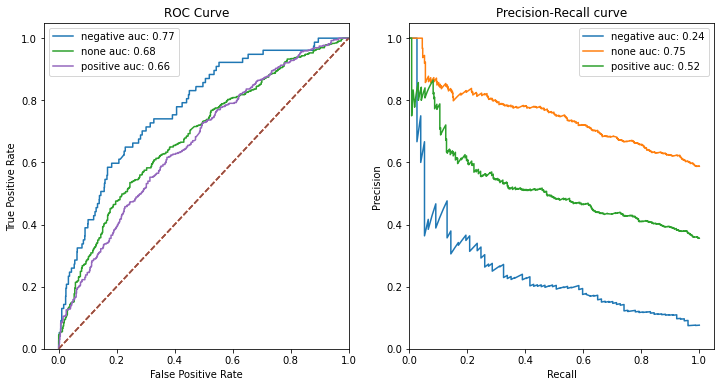

accuracy score:  0.5374 cohens kappa:  0.237
                                    precision    recall  f1-score   support

                  Negative emotion       0.19      0.58      0.28        77
No emotion toward brand or product       0.73      0.56      0.63       654
                  Positive emotion       0.50      0.49      0.49       391

                          accuracy                           0.54      1122
                         macro avg       0.47      0.54      0.47      1122
                      weighted avg       0.61      0.54      0.56      1122



In [48]:
y_pred, y_pred_p = get_pred(model, X_val['tweet'])
evaluating(y_val, y_pred, y_pred_p)

Okay. Overall accuracy is not great, but at least this does a better job at catching all three classes about 50% correctly. It seems like it's falsely biasing towards minority class though. Overall bias is high. 

## Random Forest
---
For models below, I won't use oversampled data, instead I'll rely on algorithm's own class weighting.

In [49]:
X_val_tf = tf_vectorizer.transform(X_val.tweet)

In [50]:
import optuna
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
#from sklearn.model_selection import GridSearchCV

In [ ]:
def find_hyperparam_rf(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 700)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
    class_weight = trial.suggest_categorical('class_weight', ['balanced', 'balanced_subsample'])
    max_features = trial.suggest_int('max_features', 2, X_train_tf.shape[1])
    rfc = RandomForestClassifier(oob_score = True, 
                                 n_estimators = n_estimators,
                                 min_samples_split = min_samples_split,
                                 min_samples_leaf = min_samples_leaf,
                                 criterion = criterion,
                                 class_weight = class_weight, 
                                 max_features = max_features
                                )
    cv = KFold(n_splits = 7, shuffle = True, random_state = 20)
    score = np.mean(cross_val_score(rfc, X_train_tf, y_train,
                                    scoring = 'f1_macro', cv = cv, n_jobs = -1))
    return (score)

#rfc_study = optuna.create_study(direction='maximize')
rfc_study.optimize(find_hyperparam_rf, timeout = 3600)

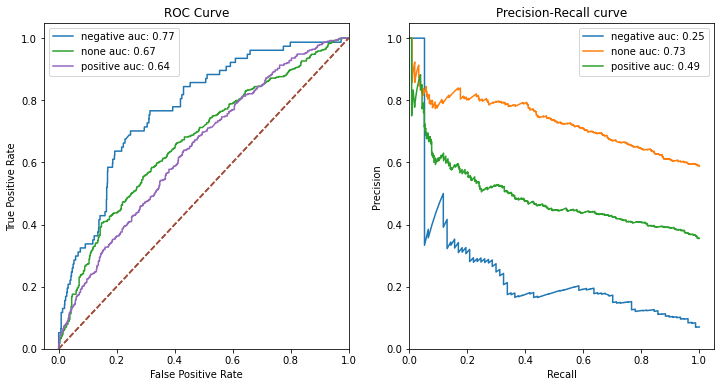

accuracy score:  0.5945 cohens kappa:  0.2496
                                    precision    recall  f1-score   support

                  Negative emotion       0.26      0.31      0.28        77
No emotion toward brand or product       0.69      0.68      0.68       654
                  Positive emotion       0.52      0.51      0.51       391

                          accuracy                           0.59      1122
                         macro avg       0.49      0.50      0.49      1122
                      weighted avg       0.60      0.59      0.60      1122



In [58]:
rf = RandomForestClassifier(**rfc_study.best_params, n_jobs = -1)

rf.fit(X_train_tf, y_train)

y_pred, y_pred_p = get_pred(rf, X_val_tf)
evaluating(y_val, y_pred, y_pred_p)

In [63]:
rfc_study.best_value

0.5162487485944782

It seems like this model generally has a low variance compared to others. But overall performance can definitely improve.

## SVM
---

In [ ]:
def find_hyperparam_svm(trial):
    C = trial.suggest_loguniform('C', 0.0001, 1)
    gamma = trial.suggest_categorical('gamma', ['scale', 'auto'])
    tol = trial.suggest_loguniform('tol', 0.00001, 0.1)
    svc = SVC(probability = True, 
              C = C,
              gamma = gamma,
              tol = tol,
              class_weight = 'balanced'
             )
    cv = KFold(n_splits = 7, shuffle = True, random_state = 20)
    score = np.mean(cross_val_score(svc, X_train_tf, y_train,
                                    scoring = 'f1_macro', cv = cv, n_jobs = -1))
    return (score)

#svm_study = optuna.create_study(direction='maximize')
svm_study.optimize(find_hyperparam_svm, timeout = 3600)

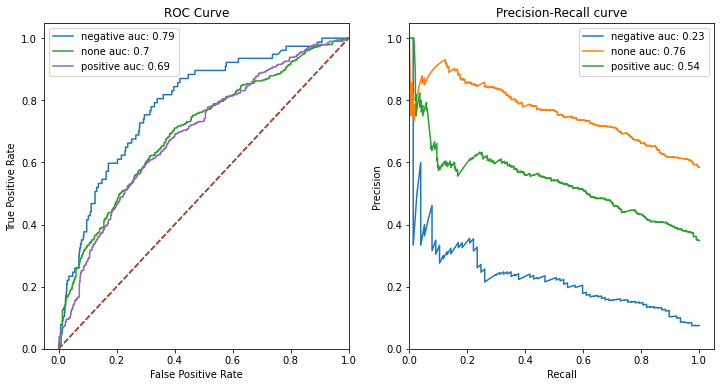

accuracy score:  0.5909 cohens kappa:  0.2655
                                    precision    recall  f1-score   support

                  Negative emotion       0.31      0.26      0.28        77
No emotion toward brand or product       0.74      0.60      0.66       654
                  Positive emotion       0.48      0.64      0.55       391

                          accuracy                           0.59      1122
                         macro avg       0.51      0.50      0.50      1122
                      weighted avg       0.62      0.59      0.60      1122



In [72]:
svm1 = SVC(class_weight = 'balanced', 
           **svm_study.best_params, 
           probability= True)

svm1.fit(X_train_tf, y_train)

y_pred, y_pred_p = get_pred(svm1, X_val_tf)
evaluating(y_val, y_pred, y_pred_p)

In [73]:
svm_study.best_value

0.5050837761294572

Slight improvement. No overfitting. But prediction of minority class is consistently bad.